In [1]:
%matplotlib inline
import sys
from u8timeseries import Prophet, KthValueAgoBaseline, ExponentialSmoothing, TimeSeries, Arima, AutoArima
from u8timeseries.models.autoregressive_model import AutoRegressiveModel
from u8timeseries import StandardRegressiveModel
from u8timeseries.metrics import mape, overall_percentage_error, mase
from u8timeseries.backtesting import simulate_forecast_ar, simulate_forecast_regr, get_train_val_series, backtest_autoregressive_model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, Dropout, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd
pd.__version__
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

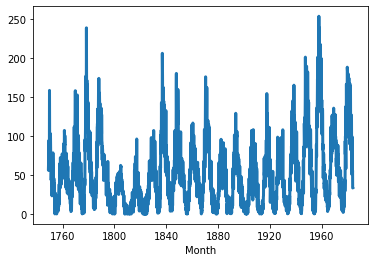

In [2]:
df = pd.read_csv('monthly-sunspots.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', 'Sunspots')
series.plot(lw=3)

In [3]:
from numpy.random import seed
seed(45)
from tensorflow import set_random_seed
set_random_seed(45)


class Seq2SeqModel(AutoRegressiveModel):
    def __init__(self, latent_dims=[20], dropout=0.0,
            recurrent_dropout=0.0, epochs=10, batch_size=1, back_steps=3, forecast_steps=3,
            validation_split=0.1, features_no=1):
        super().__init__()
        # Stores training date information:
        self.training_series: TimeSeries = None
        self.latent_dims = latent_dims
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.back_steps = back_steps
        self.forecast_steps = forecast_steps
        self.validation_split = validation_split
        self.features_no = features_no
        # state
        self._fit_called = False

    def split_dataset(self, series, back_steps, forecast_steps):
        data_in, data_out = [], []
        for i in range(len(series) - back_steps - forecast_steps):
            data_in.append(series[i:(i + back_steps)])
            data_out.append(series[(i + back_steps):(i + back_steps + forecast_steps)])
        data_in = np.array(data_in, dtype=np.float32)
        data_out = np.array(data_out, dtype=np.float32)
        data_in = data_in.reshape(data_in.shape[0], data_in.shape[1], 1)
        data_out = data_out.reshape(data_out.shape[0], data_out.shape[1], 1)
        return data_in, data_out
    
    def create_encoder_model(self):
        enc_input = Input(shape=(None, self.features_no))
        outputs = enc_input
        enc_states = []
        for j in range(len(self.latent_dims)):
            outputs, enc_h_state, enc_c_state = LSTM(self.latent_dims[j], 
                                                     return_state=True, return_sequences=(not bool(j)))(outputs)
            enc_states = [enc_h_state, enc_c_state] + enc_states
        print(enc_states)
        return enc_input, enc_states

    def create_decoder_model(self, enc_states):
        dec_input = Input(shape=(None, self.features_no))
        output = dec_input
        output_layers = []
        for j in range(len(self.latent_dims)):
            tmp_lstm = LSTM(self.latent_dims[len(self.latent_dims)-j-1], return_sequences=True,
                                                       return_state=True)
            output_layers.append(tmp_lstm)
            output, _, _ = tmp_lstm(output, initial_state=enc_states[2*j: 2*(j+1)])
            print(enc_states[2*j: 2*(j+1)], self.latent_dims[len(self.latent_dims)-j-1])
        dec_dense = TimeDistributed(Dense(self.features_no, activation=None))
        output = dec_dense(output)
        print(output_layers)
        return dec_input, output, output_layers, dec_dense
    
    def fit(self, series: TimeSeries) -> None:
        super().fit(series)
        
        self.enc_input, self.enc_states = self.create_encoder_model()
        self.dec_input, output, self.output_layers, self.dec_dense = \
                                                     self.create_decoder_model(self.enc_states)
        self.model = Model([self.enc_input, self.dec_input], output)
        self.model.compile(optimizer='adam', loss='mse')
        
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.training_series = series
        self.scaled_series = self.scaler.fit_transform(series.values().reshape(-1, 1))
        enc_in, out = self.split_dataset(self.scaled_series, self.back_steps, self.forecast_steps)
        dec_in = np.zeros_like(out)
        
        self.model.fit([enc_in, dec_in], out, epochs=self.epochs, batch_size=self.batch_size, shuffle=False,
                      validation_split=self.validation_split)
        self._fit_called = True


    def predict(self, n: int) -> TimeSeries:
        super().predict(n)
        
        in_values = self.scaled_series[-self.back_steps:]
        in_values = in_values.reshape(in_values.shape[0], in_values.shape[1], 1)
        
        encoder_model = Model(self.enc_input, self.enc_states)
        
        dec_outputs = self.dec_input
        dec_states_inputs = []
        dec_states = []
        for j in range(len(self.latent_dims))[::-1]:
            print(self.latent_dims[j])
            current_states_input = [Input(shape=(self.latent_dims[j],)) for _ in range(2)]                        
            dec_outputs, state_h, state_c = self.output_layers[len(self.latent_dims)-j-1](dec_outputs, initial_state=current_states_input)
            dec_states_inputs += [current_states_input]
            dec_states += [state_h, state_c]
            
        dec_outputs = self.dec_dense(dec_outputs)
        decoder_model = Model(
            [self.dec_input] + dec_states_inputs,
            [dec_outputs] + dec_states)
                                                     
        states_values = encoder_model.predict(in_values)
        target_seq = np.zeros((1, 1, self.features_no))

        decoded_sequence = []
        for i in range(n):
            res = decoder_model.predict(
                [target_seq] + states_values)
            output_val = res[0]
            states_values = res[1:]
            decoded_sequence.append(output_val)

            target_seq = np.zeros((1, 1, self.features_no))
            
        predictions = np.array(decoded_sequence).reshape(-1, 1)
        predictions = self.scaler.inverse_transform(predictions).reshape(-1)

        return self._build_forecast_series(predictions)

In [4]:
model_lstm = Seq2SeqModel(latent_dims=[30, 40], dropout=0.0,
            recurrent_dropout=0.4,
            epochs=60, batch_size=10, back_steps=40, forecast_steps=30)

In [ ]:
train, test = series.split_after(pd.Timestamp('19570101'))
model_lstm.fit(train)
# model_es.fit(train)
pred = model_lstm.predict(len(test))

W0806 14:22:15.478116 139907254744896 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


[<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'lstm/while/Exit_2:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'lstm/while/Exit_3:0' shape=(?, 30) dtype=float32>]
[<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 40) dtype=float32>] 40
[<tf.Tensor 'lstm/while/Exit_2:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'lstm/while/Exit_3:0' shape=(?, 30) dtype=float32>] 30
[<tensorflow.python.keras.layers.recurrent.LSTM object at 0x7f3e57e0d6d8>, <tensorflow.python.keras.layers.recurrent.LSTM object at 0x7f3e57bb1198>]
Train on 2184 samples, validate on 243 samples


W0806 14:22:16.462461 139907254744896 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/60
2184/2184 [==============================] - 13s 6ms/sample - loss: 0.1124 - val_loss: 0.1661
Epoch 2/60
2184/2184 [==============================] - 11s 5ms/sample - loss: 0.0935 - val_loss: 0.1242
Epoch 3/60
2184/2184 [==============================] - 11s 5ms/sample - loss: 0.1012 - val_loss: 0.1135
Epoch 4/60
2184/2184 [==============================] - 11s 5ms/sample - loss: 0.1145 - val_loss: 0.1639
Epoch 5/60
2184/2184 [==============================] - 11s 5ms/sample - loss: 0.0929 - val_loss: 0.1239
Epoch 6/60
2184/2184 [==============================] - 11s 5ms/sample - loss: 0.0882 - val_loss: 0.1099
Epoch 7/60
2184/2184 [==============================] - 15s 7ms/sample - loss: 0.0858 - val_loss: 0.1116
Epoch 8/60
2184/2184 [==============================] - 11s 5ms/sample - loss: 0.0890 - val_loss: 0.1124
Epoch 9/60
2184/2184 [==============================] - 11s 5ms/sample - loss: 0.0912 - val_loss: 0.1116
Epoch 10/60
2184/2184 [==============================] 

7742.251084491798


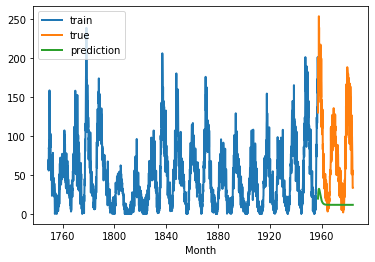

In [6]:
train.plot(lw=2, label='train')
test.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()
mse = (np.square(test.values() - pred.values())).mean()
print(mse)

## Simulate historical forecasting
Here we'll do some backtesting. We will simulate predictions that would have been done historically with a given model. It can take a while to produce, since the model is re-fit every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a *forecast horizon*, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 6 months in the future (compared to prediction time).

In [8]:
historical_fcast = simulate_forecast_ar(series, model_lstm, pd.Timestamp('19830401'), fcast_horizon_n=6, verbose=True)

Epoch 1/20
2770/2770 [==============================] - 10s 4ms/sample - loss: 0.0125
Epoch 2/20
2770/2770 [==============================] - 9s 3ms/sample - loss: 0.0109
Epoch 3/20
2770/2770 [==============================] - 10s 3ms/sample - loss: 0.0090
Epoch 4/20
2770/2770 [==============================] - 9s 3ms/sample - loss: 0.0107
Epoch 5/20
2770/2770 [==============================] - 8s 3ms/sample - loss: 0.0088
Epoch 6/20
2770/2770 [==============================] - 8s 3ms/sample - loss: 0.0091
Epoch 7/20
2770/2770 [==============================] - 8s 3ms/sample - loss: 0.0089
Epoch 8/20
2770/2770 [==============================] - 7s 3ms/sample - loss: 0.0081
Epoch 9/20
2770/2770 [==============================] - 7s 3ms/sample - loss: 0.0083
Epoch 10/20
2770/2770 [==============================] - 8s 3ms/sample - loss: 0.0079
Epoch 11/20
2770/2770 [==============================] - 8s 3ms/sample - loss: 0.0071
Epoch 12/20
2770/2770 [==============================] - 7s 3

Let's see what this backtest forecast looks like. You can see it produces more accurate predictions than the one-off prediction done above, because here the model is re-fit every month.

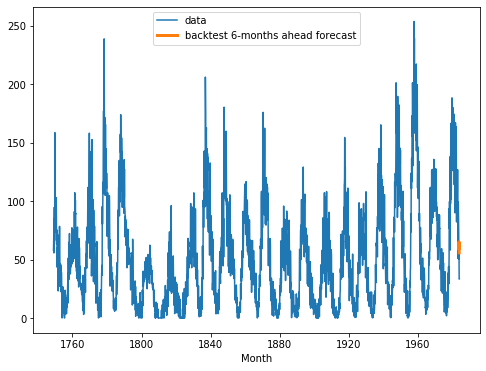

In [9]:
plt.figure(figsize=(8,6))
series.plot(label='data')
historical_fcast.plot(lw=3, label='backtest 6-months ahead forecast')
plt.legend()

## Backtest the models on the data using a user-defined metric
Here we'll do slightly more advanced backtesting, and use our own metric (in this case the MAPE error function) to compare the different models. We'll simulate 12-months ahead predictions done in the past, starting in January 1955, and the errors will be computed on the 12-months period for which forecasts are done.

In [ ]:
def backtest_model(model):
    tic = time.time()
    train_val_series = get_train_val_series(series, start=pd.Timestamp('19550101'), nr_points_val=12)
    res = backtest_autoregressive_model(model, train_val_series, mape)
    tac = time.time()
    print('Backtest done in %.2f s.' % (tac-tic))
    return res

In [ ]:
res_es = backtest_model(model_es)
res_pr = backtest_model(model_pr)
res_bl = backtest_model(model_bl)

### Plot the user-defined backtesting results

In [ ]:
plt.hist(res_es, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Exponential Smoothing');
plt.hist(res_pr, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Prophet');
plt.hist(res_bl, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Baseline');

plt.xlabel('Mean absolute percentage error (%)')
plt.ylabel('CDF')
plt.legend(loc=4)

### Let's make an actual forecast!
Since Exponential Smoothing is better in backtests, let's use this one.

In [ ]:
model_es.fit(series)
pred = model_es.predict(n = 50)

series.plot(label='data', lw=2)
pred.plot(label='forecast', lw=2)
plt.legend()

## Ensembling several predictions
### Let's simulate forecasts done by an ensemble of models

In [ ]:
""" New way - backtest over time
"""
models = [ExponentialSmoothing(), Prophet()]

historical_ar_preds = [simulate_forecast_ar(series, m, pd.Timestamp('19570101'), fcast_horizon_n=6, verbose=True)
                       for m in models]

In [ ]:
""" Combine the individual simulated predicitons
"""
regrModel = StandardRegressiveModel(train_n_points=12)

series_val = series.intersect(historical_ar_preds[0])

historical_pred = simulate_forecast_regr(historical_ar_preds, series_val, regrModel,
                                         pd.Timestamp('19580101'), fcast_horizon_n=6)

In [ ]:
""" Compute errors and plot
"""
plt.figure(figsize=(8,5))

series.plot()
for i, m in enumerate(models):
    historical_ar_preds[i].plot(label=str(m))
    
    # intersect last part, to compare everything with ensemble
    ar_pred = historical_ar_preds[i].intersect(historical_pred)
       
    mape_er = mape(series.intersect(historical_pred), ar_pred)
    print('MAPE Error {}: {}'.format(m, mape_er))

print('MAPE Error ensemble: {}'.format(mape(series.intersect(historical_pred), historical_pred)))

historical_pred.plot(label='Ensemble')

plt.legend()

## Example of forecasting using a regressive model and extra features